In this notebook the "MSFT" stock data is loaded and attempts are made to build a Machine Learning model to predict if following day stock Closing price will be higher than the day before (Closing price indicator) using Random Forest classifier. Classifier principal metrics are calculated (Recall, Precission, Accuracy, F1 score and confusion matrix). Procedure is repeated and same metrics are provided after slight feature engineering. The results obtained here act as a baseline for the subsequent work.   

<a id="top"></a>
1. [Data collection and processing](#01)  
    1. [Feature engineering](#011)
1. [Random Forest Classifier predictions](#02)
1. [LTSM for Closing price prediction](#03)
1. [Follow up](#04)

<a id="01"></a> 
# Data collection and processing
[back to top](#top)

In [42]:
import pandas as pd
import numpy as np
import yfinance as yf

ticker = 'MSFT'
ticker_data = yf.Ticker(ticker)

data = ticker_data.history(period="max")
data.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,0.055121,0.063227,0.055121,0.060524,1031788800,0.0,0.0
1986-03-14 00:00:00-05:00,0.060524,0.063767,0.060524,0.062686,308160000,0.0,0.0
1986-03-17 00:00:00-05:00,0.062686,0.064307,0.062686,0.063767,133171200,0.0,0.0
1986-03-18 00:00:00-05:00,0.063767,0.064307,0.061605,0.062145,67766400,0.0,0.0
1986-03-19 00:00:00-05:00,0.062145,0.062686,0.060524,0.061065,47894400,0.0,0.0


In [43]:
hist= data.copy(deep=True)

<Axes: xlabel='Date'>

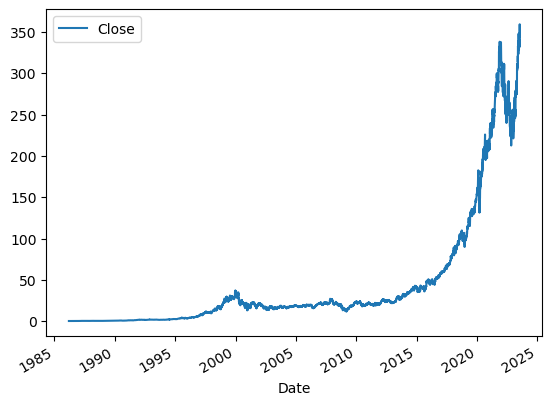

In [44]:
hist.plot.line(y="Close", use_index=True)

In [45]:
del hist["Dividends"]
del hist["Stock Splits"]

In [46]:
hist["Tomorrow"] = hist["Close"].shift(-1)
hist["Target"] = (hist["Tomorrow"] > hist["Close"]).astype(int)

In [47]:
hist = hist.loc["2000-01-01":].copy()

In [48]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

target = 'Target'
predictors = ["Close", "Volume", "Open", "High", "Low"]

train = hist.iloc[:-100]
test = hist.iloc[-100:]

model.fit(train[predictors], train[target])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [49]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5609756097560976

In [50]:
def predict(train, test, predictors, target, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)
    return combined

In [51]:
def backtest(data, model, predictors, taget, start=2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors,target, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [53]:
predictions = backtest(hist, model, predictors, target)

In [54]:
predictions["Predictions"].value_counts()

0    2130
1    1295
Name: Predictions, dtype: int64

prediction says that 1200 times the price would increase

In [55]:
precision_score(predictions["Target"], predictions["Predictions"])

0.511969111969112

In [56]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.520876
0    0.479124
Name: Target, dtype: float64

In [57]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
recall = recall_score(predictions["Target"], predictions["Predictions"])
precision = precision_score(predictions["Target"], predictions["Predictions"])
accuracy = accuracy_score(predictions["Target"], predictions["Predictions"])
f1 = f1_score(predictions["Target"], predictions["Predictions"])
print(f'Recall: {recall} \nPrecision: {precision} \nAccuracy: {accuracy} \nF1: {f1}')

Recall: 0.3716367713004484 
Precision: 0.511969111969112 
Accuracy: 0.48817518248175185 
F1: 0.43065930496914584


Recall: how many actually possitive cases were correctly identified TP/(TP+FN)  
Precision: how many positive predictions were REALLY possitive TP/(TP+FP)  
Accuracy: number of correct prediction/ number of all predictions (TP+TN)/all  

High recall: more likely to mark negative results as possitive  
                when price was going down we indicated that it will go up  
High precision: more likely to mark possitive result as negative  

In [58]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(predictions["Target"], predictions["Predictions"])

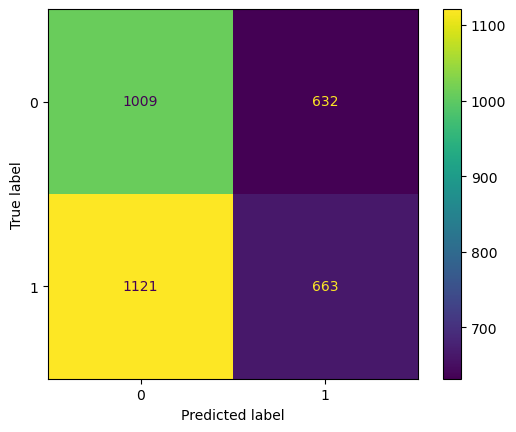

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot()
plt.show()

Model correctly identified price not increasing the following day 1012 times (TP) and correctly identified price INcreasing the following day 672 times (TN). The FN case - The Price increased while model predicted a decrease 1109 times (almost the same as TP and FP - 625. 

<a id="011"></a>
## Lets crate new predictors
[back to top](#top)

In [60]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = hist.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    hist[ratio_column] = hist["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    hist[trend_column] = hist.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [61]:
hist = hist.dropna()

In [62]:
hist.head()

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2003-12-26 00:00:00-05:00,16.988554,17.114163,16.957152,17.089041,12076900,17.246056,1,1.003134,1.0,1.000809,1.0,1.010060,31.0,1.048220,129.0,0.894302,489.0
2003-12-29 00:00:00-05:00,17.089045,17.290020,17.057643,17.246056,40426700,17.283739,1,1.004573,2.0,1.009262,2.0,1.019896,32.0,1.057551,130.0,0.903361,490.0
2003-12-30 00:00:00-05:00,17.214654,17.302580,17.208373,17.283739,34406600,17.189533,0,1.001091,2.0,1.008946,3.0,1.023010,32.0,1.059716,130.0,0.906196,490.0
2003-12-31 00:00:00-05:00,17.220935,17.302580,17.101606,17.189533,42198900,17.239771,1,0.997267,1.0,1.001830,3.0,1.018480,31.0,1.053825,129.0,0.902063,490.0
2004-01-02 00:00:00-05:00,17.321416,17.440744,17.164405,17.239771,44487700,17.673126,1,1.001459,1.0,1.001752,4.0,1.022425,32.0,1.056855,129.0,0.905529,490.0


<a id='02'></a>
# Predictions
[back to top](#top)

Close price indicator prediction

In [63]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [64]:
def predict(train, test, predictors, target, model, thrsh = 0.6):
    #0.6 probability threshold so that we have a better confidence that price will increase
    model.fit(train[predictors], train[target])
    preds = model.predict_proba(test[predictors])[:,1] #predicts probability
    preds[preds >=thrsh] = 1
    preds[preds <thrsh] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)
    return combined

In [66]:
target = 'Target'
#predictors = predictors + new_predictors
predictors = new_predictors + ["Close", "Volume"] #the other prices tell us little about the prediction 
print('Predictors:')
print(predictors)
predictions = backtest(hist, model, predictors, target)

Predictors:
['Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250', 'Close_Ratio_1000', 'Trend_1000', 'Close', 'Volume']


In [67]:
predictions["Predictions"].value_counts()

0.0    2231
1.0     193
Name: Predictions, dtype: int64

So now we only predict 200 days when price will increase in contrary to rpevious results where it was 1200

In [68]:
precision_score(predictions["Target"], predictions["Predictions"])

0.49222797927461137

In [69]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.528878
0    0.471122
Name: Target, dtype: float64

In [70]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(predictions["Target"], predictions["Predictions"])
cf_matrix

array([[1044,   98],
       [1187,   95]], dtype=int64)

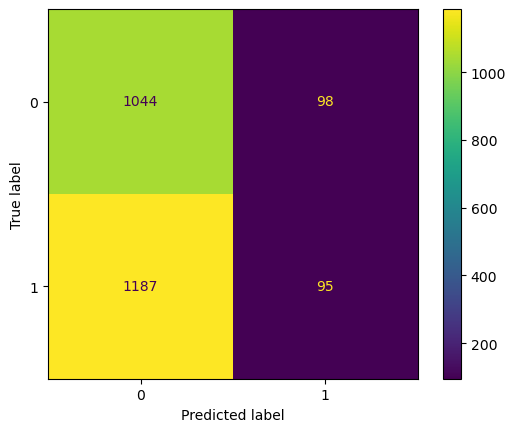

In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot()
plt.show()

In [72]:
recall = recall_score(predictions["Target"], predictions["Predictions"])
precision = precision_score(predictions["Target"], predictions["Predictions"])
accuracy = accuracy_score(predictions["Target"], predictions["Predictions"])
f1 = f1_score(predictions["Target"], predictions["Predictions"])
print(f'Recall: {recall} \nPrecision: {precision} \nAccuracy: {accuracy} \nF1: {f1}')

Recall: 0.07410296411856475 
Precision: 0.49222797927461137 
Accuracy: 0.4698844884488449 
F1: 0.12881355932203392


<a id="03"></a>
# LTSM for Closing price prediction
[back to top](#top)


Attempt to use only Closing price to predict next day stock Price  
We reform the dataset that each sample contains several days history info (5 and 20 days)

In [127]:
df_close = hist['Close'].copy(deep=True)
df_close = df_close.reset_index(drop=True)

In [162]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df_close=pd.DataFrame(scaler.fit_transform(np.array(df_close).reshape(-1, 1)), columns= ['Close'])

In [163]:
df_close

,Close
0,0.016480
1,0.016932
2,0.017040
3,0.016769
4,0.016913
...,...
4919,0.959068
4920,0.960476
4921,1.000000
4922,0.987333


In [177]:
def rebuild_dataset(in_df: pd.DataFrame, nr_days: int, feat_name : str, period_shift : int = 1) -> pd.DataFrame:
    """ We put <window size> amount of data into singular row
    in_df - input DataFrame
    nr_days - number of days of history
    feat_name - which feature to use
    period_shift - number of days between successive data samples
    """
    #window_size determines how many data points in the past we are interested
    column_names = [('X'+str(y+1)) for y in range(0,nr_days)]
    column_names.append('Y')
    df = pd.DataFrame(columns = column_names)
    for row_i in range(0,in_df.shape[0]-nr_days, period_shift):
        window_data = []
        for i in range(nr_days):
            window_data.append(in_df[feat_name].iloc[row_i+i])
        window_data.append(in_df[feat_name].iloc[row_i+i+1])
        df.loc[in_df.index[row_i]] = window_data
    return df

In [238]:
reformed_df_20 = rebuild_dataset(df_close, 20, 'Close')
reformed_df_5 = rebuild_dataset(df_close, 5, 'Close')

In [239]:
reformed_df_20.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X12,X13,X14,X15,X16,X17,X18,X19,X20,Y
0,0.016480,0.016932,0.017040,0.016769,0.016913,0.018158,0.018339,0.018285,0.018194,0.017292,...,0.016877,0.017364,0.017076,0.017563,0.018086,0.018447,0.017924,0.018772,0.019349,0.018357
1,0.016932,0.017040,0.016769,0.016913,0.018158,0.018339,0.018285,0.018194,0.017292,0.017130,...,0.017364,0.017076,0.017563,0.018086,0.018447,0.017924,0.018772,0.019349,0.018357,0.017382
2,0.017040,0.016769,0.016913,0.018158,0.018339,0.018285,0.018194,0.017292,0.017130,0.016877,...,0.017076,0.017563,0.018086,0.018447,0.017924,0.018772,0.019349,0.018357,0.017382,0.017743
3,0.016769,0.016913,0.018158,0.018339,0.018285,0.018194,0.017292,0.017130,0.016877,0.017364,...,0.017563,0.018086,0.018447,0.017924,0.018772,0.019349,0.018357,0.017382,0.017743,0.017274
4,0.016913,0.018158,0.018339,0.018285,0.018194,0.017292,0.017130,0.016877,0.017364,0.017076,...,0.018086,0.018447,0.017924,0.018772,0.019349,0.018357,0.017382,0.017743,0.017274,0.016823


So here we take 20 previous days 'Closing price' and try to predict day 4 (Y) price

Let's try to build a stacked LSTM Neural network

In [270]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import tensorflow as tf


def compile_nn(predictors):
    nr_inputs = len(predictors)

    model = Sequential([layers.Input((nr_inputs, 1)),
                        layers.LSTM(64, return_sequences=True), 
                        layers.LSTM(64, return_sequences=True),
                        layers.LSTM(32),
                        layers.Dense(1)])

    model.compile(loss = 'mse',
                    optimizer = Adam(learning_rate=0.001), 
                    metrics = ['mean_squared_error'])
    print(model.summary())
    return model

In [272]:
from keras.callbacks import EarlyStopping

in_df = reformed_df_20

predictors_20 = list(in_df.columns)[:-1]
target = 'Y'

q80 = int(in_df.shape[0]*0.8)
q90 = int(in_df.shape[0]*0.9) 
train_20 = in_df.iloc[:q80]
val_20 = in_df.iloc[q80:q90]
test_20 = in_df.iloc[q90:]

es = EarlyStopping(monitor='mean_squared_error', mode='min', verbose=1, patience=10, min_delta = 1)

model_20 = compile_nn(predictors_20)
history_20 = model_20.fit(np.array(train_20[predictors_20]), np.array(train_20[target])
                    ,validation_data=(val_20[predictors_20], val_20[target])
                    ,epochs=50
                    ,callbacks = [es]
                   )

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_63 (LSTM)              (None, 20, 64)            16896     
                                                                 
 lstm_64 (LSTM)              (None, 20, 64)            33024     
                                                                 
 lstm_65 (LSTM)              (None, 32)                12416     
                                                                 
 dense_25 (Dense)            (None, 1)                 33        
                                                                 
Total params: 62,369
Trainable params: 62,369
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
123/123 [==============================] - 13s 57ms/step - loss: 4.5587e-04 - mean_squared_error: 4.5587e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoc

In [273]:
from keras.callbacks import EarlyStopping

in_df = reformed_df_5

predictors_5 = list(in_df.columns)[:-1]
target = 'Y'

q80 = int(in_df.shape[0]*0.8)
q90 = int(in_df.shape[0]*0.9) 
train_5 = in_df.iloc[:q80]
val_5 = in_df.iloc[q80:q90]
test_5 = in_df.iloc[q90:]

es = EarlyStopping(monitor='mean_squared_error', mode='min', verbose=1, patience=10, min_delta = 1)

model_5 = compile_nn(predictors_5)
history_5 = model_5.fit(np.array(train_5[predictors_5]), np.array(train_5[target])
                    ,validation_data=(val_5[predictors_5], val_5[target])
                    ,epochs=50
                    ,callbacks = [es]
                   )

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 5, 64)             16896     
                                                                 
 lstm_67 (LSTM)              (None, 5, 64)             33024     
                                                                 
 lstm_68 (LSTM)              (None, 32)                12416     
                                                                 
 dense_26 (Dense)            (None, 1)                 33        
                                                                 
Total params: 62,369
Trainable params: 62,369
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
123/123 [==============================] - 9s 25ms/step - loss: 9.5029e-04 - mean_squared_error: 9.5029e-04 - val_loss: 2.7777e-04 - val_mean_squared_error: 2.7777e-

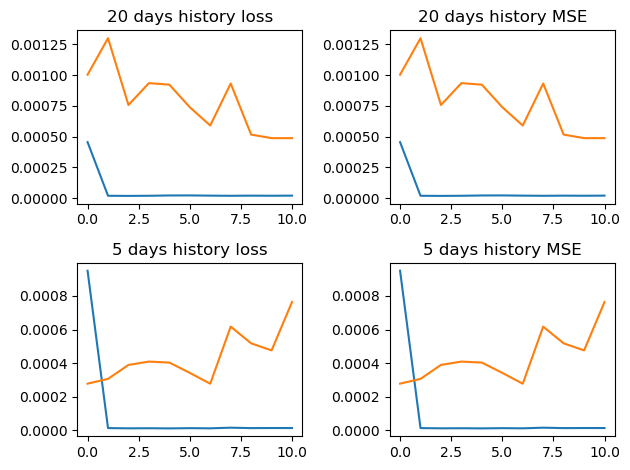

In [276]:
fig, ax = plt.subplots(2,2)
ax[0,0].plot(history_20.history['loss'], label = 'Training loss')
ax[0,0].plot(history_20.history['val_loss'], label = 'Validation loss')
ax[0,1].plot(history_20.history['mean_squared_error'], label = 'Training mse')
ax[0,1].plot(history_20.history['val_mean_squared_error'], label = 'Validation mse')
ax[0,0].set_title('20 days history loss')
ax[0,1].set_title('20 days history MSE')

ax[1,0].plot(history_5.history['loss'], label = 'Training loss')
ax[1,0].plot(history_5.history['val_loss'], label = 'Validation loss')
ax[1,1].plot(history_5.history['mean_squared_error'], label = 'Training mse')
ax[1,1].plot(history_5.history['val_mean_squared_error'], label = 'Validation mse')
ax[1,0].set_title('5 days history loss')
ax[1,1].set_title('5 days history MSE')
plt.tight_layout();

In [275]:
train_predictions_5 = scaler.inverse_transform(model_5.predict(train_5[predictors_5]).flatten().reshape(1, -1))[0]
val_predictions_5 = scaler.inverse_transform(model_5.predict(val_5[predictors_5]).flatten().reshape(1, -1))[0]
test_predictions_5 = scaler.inverse_transform(model_5.predict(test_5[predictors_5]).flatten().reshape(1, -1))[0]
train_predictions_20 = scaler.inverse_transform(model_20.predict(train_20[predictors_20]).flatten().reshape(1, -1))[0]
val_predictions_20 = scaler.inverse_transform(model_20.predict(val_20[predictors_20]).flatten().reshape(1, -1))[0]
test_predictions_20 = scaler.inverse_transform(model_20.predict(test_20[predictors_20]).flatten().reshape(1, -1))[0]

16/16 [==============================] - 0s 23ms/step


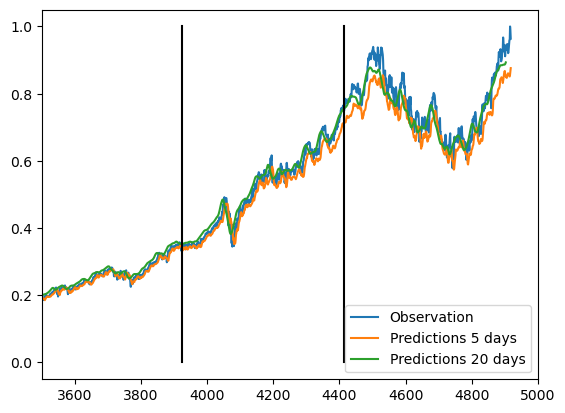

In [278]:
conc_preds_5 = np.concatenate((train_predictions_5, val_predictions_5, test_predictions_5))
conc_preds_20 = np.concatenate((train_predictions_20, val_predictions_20, test_predictions_20))

conc_obs = np.concatenate((train[target], val[target], test[target]))

plt.plot(conc_obs, label = 'Observation')
plt.plot(conc_preds_5, label = 'Predictions 5 days')
plt.plot(conc_preds_20, label = 'Predictions 20 days')


plt.plot((len(train_predictions), len(train_predictions)),(0, max(conc_obs)), color = 'k')
plt.plot((len(train_predictions)+len(val_predictions), len(train_predictions)+len(val_predictions)),(0, max(conc_obs)), color = 'k')

plt.xlim(3500,5000)
plt.legend()
plt.show()

In [285]:
print('5 day history:')
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test_5[target], test_predictions_5)
print(f'RMSE: {error}')

5 day history:
RMSE: 0.0032901682220259592


In [286]:
print('20 day history:')
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test_20[target], test_predictions_20)
print(f'RMSE: {error}')

20 day history:
RMSE: 0.0017008631433523666


<a id="04"></a>
# Follow up
[back to top](#top)

The follow up to this baseline prediction is continued in the succeeding Jupyter notebook